# 线性函数值近似
## 1.环境设置
相比于之前实验中的奖励值，我把奖励和惩罚值都调小了，以便展示出的图更加平缓

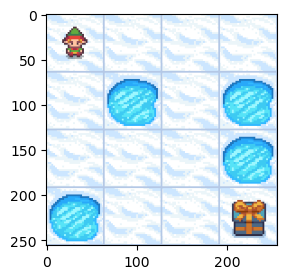

In [1]:
# 导入游戏库，定义游戏环境
import gym
import pygame
# 定义游戏环境
class myFrozenLake(gym.Wrapper):
    def __init__(self):
        #is_slippery控制会不会滑
        env = gym.make('FrozenLake-v1',
                       render_mode='rgb_array',
                       is_slippery=False)
        super().__init__(env)
        self.env = env

    def reset(self):
        state, _ = self.env.reset()
        return state

    def step(self, action):

        # 获取当前状态
        current_state = self.env.s
        # 执行动作，获取结果
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        # 判断是否撞墙
        if state == current_state:
            reward = -2  # 撞墙扣10分

        #走一步扣一分,逼迫机器人尽快结束游戏
        if not over:
            reward = -1

        #掉坑扣100分，游戏它本身规则就是掉坑就停止
        if over and reward == 0:
            reward = -3

        # 判断是否到达终点
        if over and reward == 1:  # 终点奖励本来就是1
            reward = 3  # 到达终点加100分

        return state, reward, over
    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()

env = myFrozenLake()
env.reset()

env.show()

## 2.使用Q-Learning获取真实的Value值

In [2]:
# 初始化action value表（Q表）
import numpy as np
Q = np.zeros((16, 4))
# 初始化一个随机的策略
pi = np.random.randint(low=0, high=4, size=16)

In [3]:
import random
# Q-Learning  On-policy算法
def QL_OnPolicy(env, Q, pi, alpha=0.1, gamma=0.9, epsilon=0.01,episodes=1000):
    for episode in range(episodes):
        current_state = env.reset()
        action = pi[current_state]
        done = False
        reward = 0
        while not done:

            next_state, reward, done = env.step(action)
            next_action = pi[next_state]

            Q[current_state, action] = Q[current_state, action] - alpha * (
                    Q[current_state, action] - (reward + gamma * np.max(Q[next_state]))
            )
            if random.random() < epsilon:
                pi[current_state] = env.action_space.sample()
            else:
                pi[current_state] = np.argmax(Q[current_state])

            current_state = next_state
            action = next_action

        if episode % 100 == 0:
            print(f"Episode: {episode}, Total Reward: {reward}")

    return Q,pi

In [4]:
Q, pi = QL_OnPolicy(env, Q, pi)
Q

Episode: 0, Total Reward: -3
Episode: 100, Total Reward: 3
Episode: 200, Total Reward: 3
Episode: 300, Total Reward: 3
Episode: 400, Total Reward: 3
Episode: 500, Total Reward: 3
Episode: 600, Total Reward: 3
Episode: 700, Total Reward: 3
Episode: 800, Total Reward: 3
Episode: 900, Total Reward: 3


array([[-2.95470813, -2.32363   , -2.816401  , -2.91268262],
       [-2.11325446, -2.15271139, -2.04496262, -2.20646566],
       [-1.35793764, -1.00177708, -1.37725235, -1.43736931],
       [-1.27313367, -1.22853   , -1.19282613, -1.27447674],
       [-2.12702091, -1.4707    , -2.3823266 , -2.3105026 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.813     ,  0.40294807, -0.813     , -0.75679901],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-1.45372299, -1.83773853, -0.523     , -1.74794114],
       [-0.70388827, -0.63657245,  0.53      , -1.405677  ],
       [-0.23869002,  1.7       , -0.813     , -0.43928579],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.3       , -0.19      ,  0.4606973 , -0.2233    ],
       [-0.1       ,  0.69557651,  3.        ,  0.1007    ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

## 3.将结果绘制成一个3D曲面图

In [5]:
Value = np.zeros((4,4))
row, col = 0, 0
for state in range(len(Q)):
    maxActIdx = np.argmax(Q[state])
    maxValue = Q[state, maxActIdx]

    # 将状态转换为 Value 表格中的行和列索引
    row = state // 4  # 使用 // 获取整除结果
    col = state % 4  # 使用 % 获取余数

    Value[row, col] = maxValue

Value

array([[-2.32363   , -2.04496262, -1.00177708, -1.19282613],
       [-1.4707    ,  0.        ,  0.40294807,  0.        ],
       [-0.523     ,  0.53      ,  1.7       ,  0.        ],
       [ 0.        ,  0.4606973 ,  3.        ,  0.        ]])

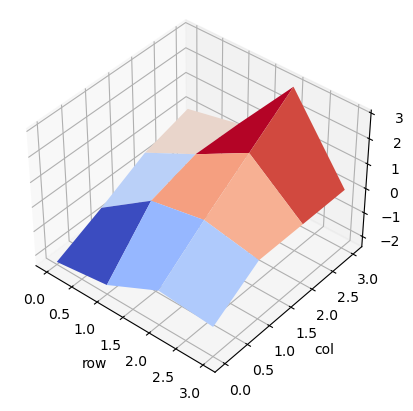

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 创建网格坐标
x, y = np.meshgrid(np.arange(4), np.arange(4))

# 创建 3D 图像
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面
ax.plot_surface(x, y, Value, cmap='coolwarm')

# 设置轴标签
ax.set_xlabel('row')
ax.set_ylabel('col')
ax.set_zlabel('Value')
ax.view_init(elev=40, azim=-50)
# 显示图像
plt.show()

## 4.线性函数值近似
$$
w_{t+1}=w_{t}+\alpha_t[r_{t+1}+\gamma \phi^T(s_{t+1})w_t-\phi^T(s_{t})w_t]\phi(s_t) \\
w_{t+1}=w_t+\alpha_t[r_{t+1}+\gamma \hat{q}(s_{t+1},a_{t+1},w_t)-\hat{q}(s_t,a_t,w_t)]\nabla_w \hat{q}(s_t,a_t,w_t) \\
\phi(s_t) = \hat{q}(s_t,a_t,w_t)
$$
其中,
- 本次实验的向量使用独热编码，该向量只与当前状态有关，而与当前动作无关
- 权重值为$w(a)$,即权重值与动作有关，由于特征向量采用独热编码，则要有对应16个状态的4个动作的权重矩阵（16行，4列），当代理执行一个动作时，就以那个动作所在的一列（即$w(a)^T$）与特征向量$\phi(s)$点乘，得到当前动作值$\hat{q}$
- 以上用公式，描述为$\hat{q}(s, a, w) = w(a)^T · \phi(s)$
row, col为当前状态的行和列

In [131]:
def Sarsa_td_linear(env, alpha=0.1, gamma=0.9, episodes=1000, epsilon=0.1):
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    # 初始化权重矩阵
    weights = np.zeros((num_states, num_actions))

    policy = np.zeros(num_states, dtype=int)

    for episode in range(episodes):
        current_state = env.reset()
        done = False


        while not done:
            current_action = policy[current_state]
            current_vector = np.eye(num_states)[current_state]  # 使用 one-hot 编码作为特征向量

            next_state, reward, done= env.step(current_action)
            next_vector = np.eye(num_states)[next_state]

            next_action = policy[next_state]

            # 计算TD目标
            # weights[:, action]即当前动作对应的权重
            td_target = reward + gamma * np.dot(next_vector, weights[:, next_action])
            td_error = td_target - np.dot(current_vector, weights[:, current_action])

            # 更新权重
            weights[:, current_action] += alpha * td_error * current_vector

            # 策略更新
            if np.random.rand() < epsilon:
                policy[current_state] = env.action_space.sample()
            else:
                policy[current_state] = np.argmax(np.dot(current_vector, weights))

            current_state = next_state

    return weights, policy


In [135]:
# 使用Q-Learning应用线性数值近似
def QLearning_td_linear(env, alpha=0.1, gamma=0.9, episodes=1000, epsilon=0.1):

    num_states = env.observation_space.n
    num_actions = env.action_space.n

    # 初始化权重矩阵
    weights = np.zeros((num_states, num_actions))
    policy = np.zeros(num_states, dtype=int)

    for episode in range(episodes):
        current_state = env.reset()
        done = False

        while not done:
            current_action = policy[current_state]
            current_vector = np.eye(num_states)[current_state]  # 使用 one-hot 编码作为特征向量

            next_state, reward, done= env.step(current_action)
            next_vector = np.eye(num_states)[next_state]


            # 计算TD目标
            next_action = np.argmax(np.dot(next_vector, weights))
            q_hat_max = np.dot(next_vector, weights[:, next_action])
            td_target = reward + gamma * q_hat_max
            td_error = td_target - np.dot(current_vector, weights[:, current_action])

            # 更新权重
            weights[:, current_action] += alpha * td_error * current_vector

            # 策略更新
            if np.random.rand() < epsilon:
                policy[current_state] = env.action_space.sample()
            else:
                policy[current_state] = np.argmax(np.dot(current_vector, weights))

            current_state = next_state

    return weights, policy

In [138]:
# 训练 TD-linear 算法
env.reset()
weights, policy = QLearning_td_linear(env)
weights

array([[-3.08532821, -2.32363   , -2.64338588, -3.08980089],
       [-2.23988795, -2.15271139, -1.66340413, -2.14011477],
       [-1.49105806, -0.58391594, -1.55328323, -1.56265584],
       [-1.37767933, -1.405677  , -1.39941645, -1.37773951],
       [-2.31809711, -1.4707    , -2.9324148 , -3.03333623],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-0.813     ,  0.52771328, -1.5651093 , -0.94797338],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-1.46983081, -2.85869614, -0.523     , -2.20241969],
       [-1.39446993,  0.30757268,  0.53      , -2.76070067],
       [-0.49282733,  1.7       , -2.73411186, -0.54296059],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [-1.0317    , -0.12865293,  1.69010944, -0.280243  ],
       [ 0.42664899,  1.39295148,  3.        ,  0.40775489],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [139]:
# 取得每一个状态的Q值
Value_Sarsa = np.zeros((4,4))
row, col = 0, 0
for state in range(len(weights)):
    maxActIdx = np.argmax(weights[state])
    maxValue = weights[state, maxActIdx]

    # 将状态转换为 Value 表格中的行和列索引
    row = state // 4  # 使用 // 获取整除结果
    col = state % 4  # 使用 % 获取余数

    Value_Sarsa[row, col] = maxValue

Value_Sarsa

array([[-2.32363   , -1.66340413, -0.58391594, -1.37767933],
       [-1.4707    ,  0.        ,  0.52771328,  0.        ],
       [-0.523     ,  0.53      ,  1.7       ,  0.        ],
       [ 0.        ,  1.69010944,  3.        ,  0.        ]])

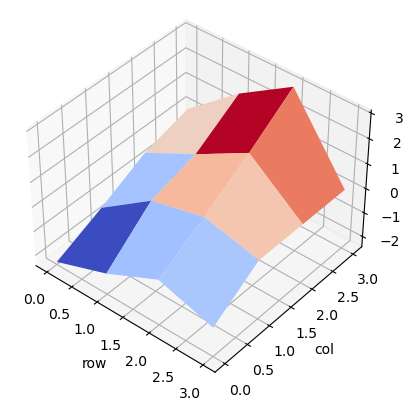

In [140]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 创建网格坐标
x, y = np.meshgrid(np.arange(4), np.arange(4))

# 创建 3D 图像
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制曲面
ax.plot_surface(x, y, Value, cmap='coolwarm')

# 设置轴标签
ax.set_xlabel('row')
ax.set_ylabel('col')
ax.set_zlabel('Value')
ax.view_init(elev=40, azim=-50)
# 显示图像
plt.show()